<a href="https://colab.research.google.com/github/HarshCasper/Brihaspati/blob/master/COVID-19/COVID19-XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/s/fwn42pc55e388a1/keras-covid-19.zip?dl=0 -O keras-covid-19.zip

--2020-03-27 03:50:41--  https://www.dropbox.com/s/fwn42pc55e388a1/keras-covid-19.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fwn42pc55e388a1/keras-covid-19.zip [following]
--2020-03-27 03:50:46--  https://www.dropbox.com/s/raw/fwn42pc55e388a1/keras-covid-19.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce74faa5700574d1abd8546094.dl.dropboxusercontent.com/cd/0/inline/A0rLJO98sRgwZECwIfXOaYTLPUtYAxeMULsF_q-bCIlojseGK_noFbPUDEAZAtBsnC3VpxsHDFWqUJcI1GQkDGQi2RLhPoXdyCOuNNOHgmWdVf1Pk51zb2zbvX-Bb3Co9z4/file# [following]
--2020-03-27 03:50:46--  https://ucce74faa5700574d1abd8546094.dl.dropboxusercontent.com/cd/0/inline/A0rLJO98sRgwZECwIfXOaYTLPUtYAxeMULsF_q-bCIlojseGK_noFbPUDEAZAtBsnC3VpxsHDFWqUJcI1GQkDGQi2RL

In [0]:
!unzip -q -o /content/keras-covid-19.zip

In [3]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
dataset = "/content/keras-covid-19/dataset"
plot = "/content/keras-covid-19/plot.png" 
model = "/content/keras-covid-19/covid19.model"

In [0]:
args={}
args["dataset"]=dataset
args["plot"]=plot
args["model"]=model

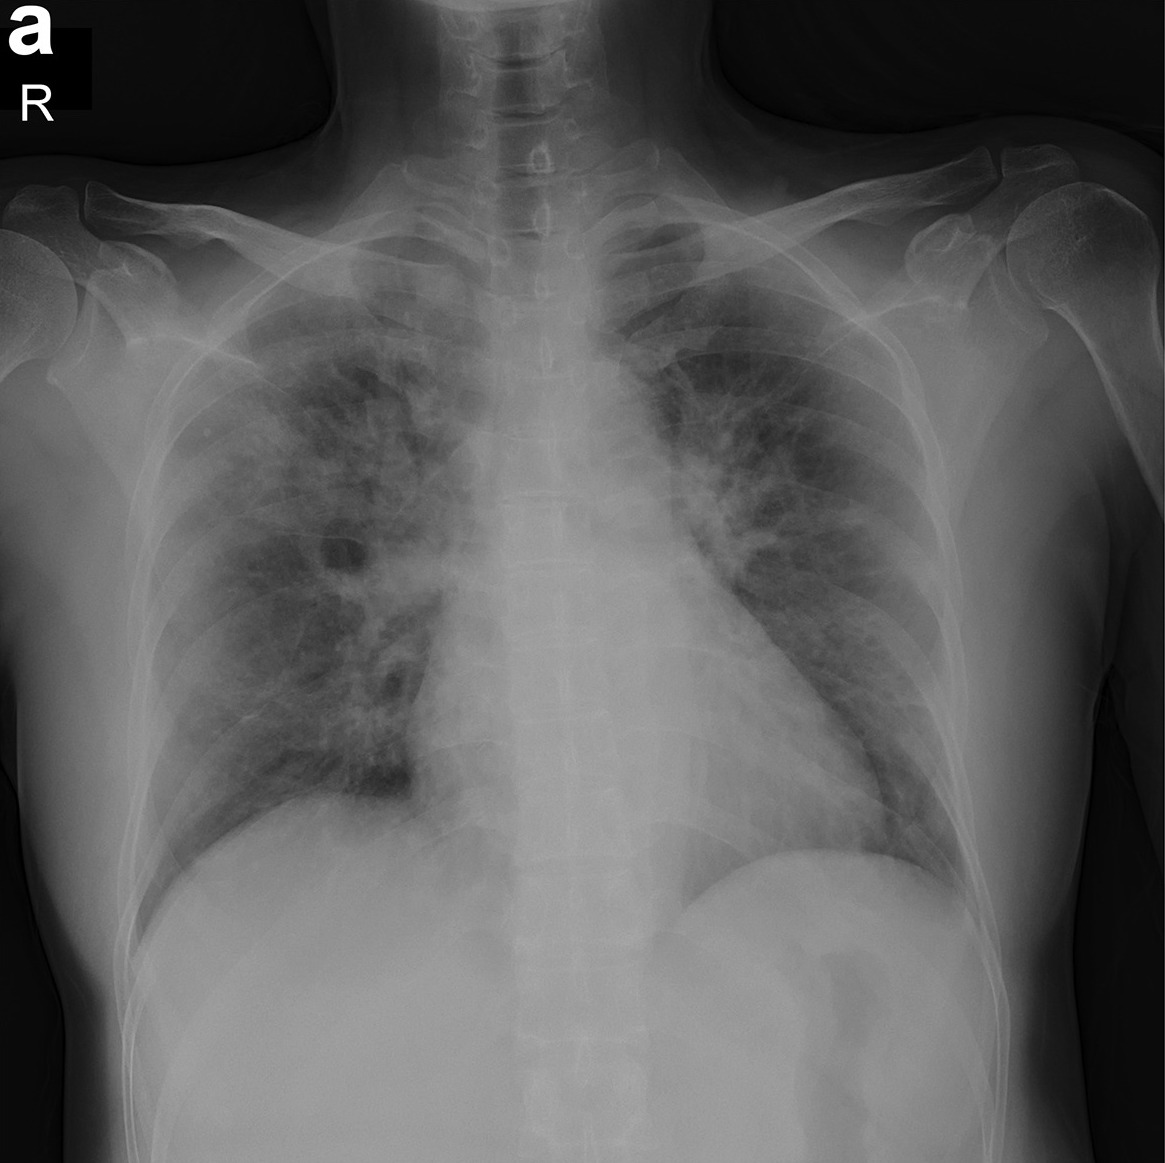

In [6]:
from IPython.display import Image, display
display(Image('/content/keras-covid-19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg',width=420))

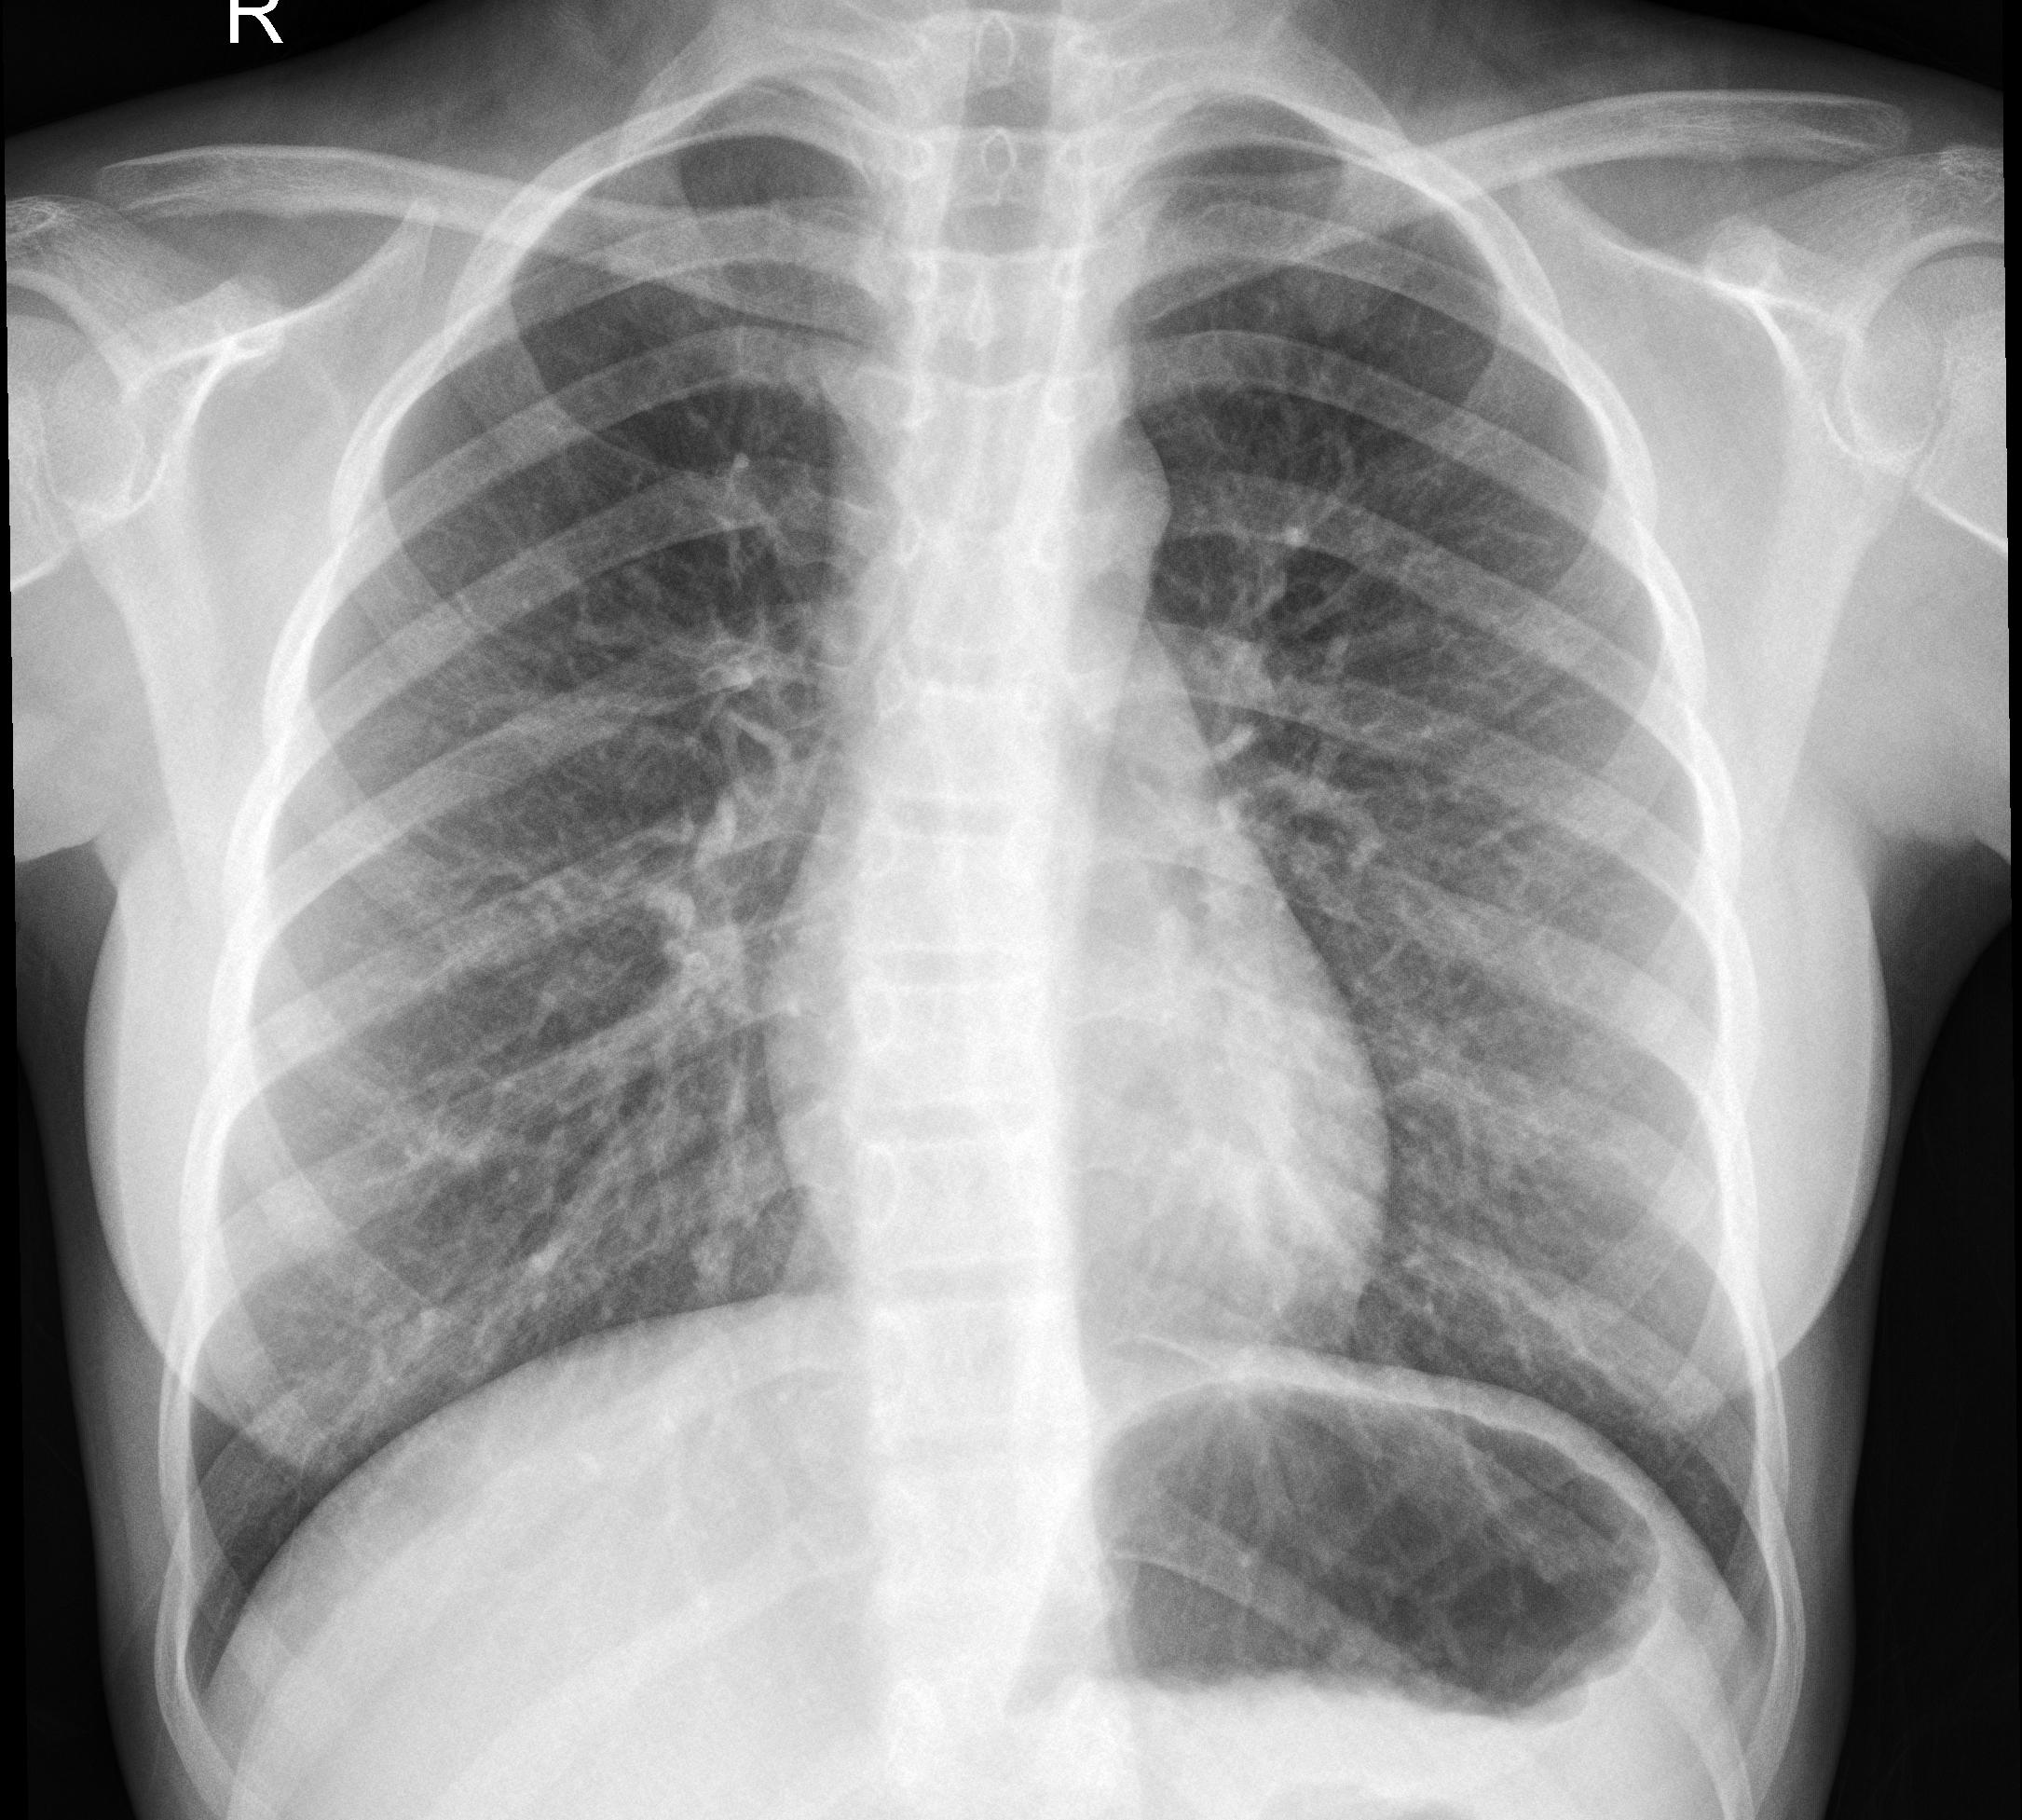

In [7]:
from IPython.display import Image, display
display(Image('/content/keras-covid-19/dataset/normal/IM-0033-0001-0001.jpeg',width=420))

In [8]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	data.append(image)
	labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [11]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 26s 5s/step - loss: 1.0197 - acc: 0.4750 - val_loss: 0.7026 - val_acc: 0.6000
Epoch 2/25
5/5 [==============================] - 25s 5s/step - loss: 0.7298 - acc: 0.6000 - val_loss: 0.7384 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 25s 5s/step - loss: 0.7837 - acc: 0.4750 - val_loss: 0.7284 - val_acc: 0.5000
Epoch 4/25
5/5 [==============================] - 25s 5s/step - loss: 0.7932 - acc: 0.5500 - val_loss: 0.6608 - val_acc: 0.5000
Epoch 5/25
5/5 [==============================] - 25s 5s/step - loss: 0.6494 - acc: 0.6250 - val_loss: 0.6244 - val_acc: 0.7000
Epoch 6/25
5/5 [==============================] - 25s 5s/step - loss: 0.6294 - acc: 0.6000 - val_loss: 0.6282 - val_acc: 0.6000
Epoch 7/25
5/5 [==============================] - 26s 5s/step - loss: 0.6156 - acc: 0.72

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.80      0.80      0.80         5
      normal       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [13]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [1 4]]
acc: 0.8000
sensitivity: 0.8000
specificity: 0.8000


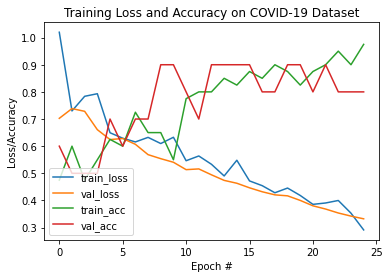

In [14]:
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])